<a href="https://colab.research.google.com/github/strangeworks/examples/blob/master/examples/optimization/quera/unit_disk_graph.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>

# Installation

In [ ]:
%pip install -q -U pip && pip install -q strangeworks-optimization

## Authentication

### Google Colab

If running in Google Colab first set your API token as a secret environment variable in Colab. You can do this by clicking on the key icon on the left, then adding a key called `STRANGEWORKS_API_KEY` with your API token as the value.

Then, run the cell below to authenticate.

In [2]:
import strangeworks as sw
from google.colab import userdata

api_key = userdata.get('STRANGEWORKS_API_KEY')
sw.authenticate(api_key)

### Local

If running locally, you can save your API token in a dotenv file. Create a file called `.env` in the same directory as this notebook and add the following line to the file:

```
STRANGEWORKS_API_KEY=your_api_token
```

Then, run the cell below to authenticate.

In [2]:
# %pip install python-dotenv
# import strangeworks as sw
# import os
# from dotenv import load_dotenv

# load_dotenv()
# api_key = os.getenv("STRANGEWORKS_API_KEY")
# sw.authenticate(api_key)

# Unit Disk Graph

Aquila is also compatible with the [Strangeworks Optimization Service](https://docs.strangeworks.com/optimization), where it can be used to solve unit disk graph (UDG) problems.

A unit disk graph is a type of geometric graph where each vertex represents a disk of unit radius in a plane, and there is an edge between two vertices if and only if their corresponding disks intersect or overlap. This method of graph construction is often used in wireless networking to model the possible connections between nodes (such as transmitters or devices) with limited communication range.

In [1]:
from strangeworks_optimization import StrangeworksOptimizer
import numpy as np
from strangeworks_optimization_models.problem_models import AquilaNDArray
from strangeworks_optimization_models.parameter_models import AquilaParameterModel
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
def plot_graph(model):
    G = nx.Graph()

    for i, (x, y) in enumerate(model.data):
        G.add_node(i, pos=(x, y))

    # Add edges based on unit disk radius
    unit_disk_radius = 1.68
    for i in range(len(model.data)):
        for j in range(i + 1, len(model.data)):
            if np.linalg.norm(model.data[i] - model.data[j]) <= unit_disk_radius:
                G.add_edge(i, j)

    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
    plt.show()

def plot_solution(model, results, unit_disk_radius):
    dist = np.sqrt((model[:, 0] - model[:, 0, None]) ** 2 + (model[:, 1] - model[:, 1, None]) ** 2)
    G = nx.relabel.convert_node_labels_to_integers(nx.Graph(dist < unit_disk_radius))
    G.remove_edges_from(nx.selfloop_edges(G))

    mis_solutions = []
    for solution in results.solution:
        bitstring = np.array(solution)
        inds = np.nonzero(bitstring == 0)[0]
        if inds.size:
            inds2 = nx.maximal_independent_set(nx.subgraph(G, inds), seed=0)
            payload = np.ones(len(bitstring))
            payload[inds2] = 0
            mis_solutions.append(payload)

    best_sol = mis_solutions[np.argmax(np.sum(1 - np.asarray(mis_solutions), axis=1))]
    seqs_color = ["#BDEE9B" if best_sol[j] == 0 else "#408EA5" for j in range(len(best_sol))]

    fig, pos_dict = plt.figure(figsize=(8, 5)), {a: model[a] for a in range(model.shape[0])}
    nx.draw_networkx_edges(G, pos_dict, width=10 / np.sqrt(len(G.nodes)), edge_color="#CE0074")
    nx.draw_networkx_nodes(G, pos_dict, node_size=1225 / np.sqrt(len(G.nodes)), node_color=seqs_color)
    fig.set_facecolor("#00000F")
    plt.show()

## Define the model

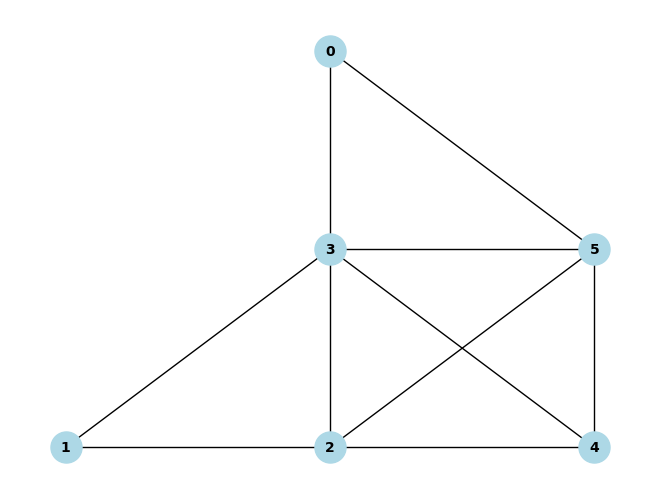

In [15]:
model = AquilaNDArray(np.array([[1, 2], [0, 0], [1, 0], [1, 1], [2, 0], [2, 1]]))

unit_disk_radius = 1.68
shots = 100
options = AquilaParameterModel(unit_disk_radius=unit_disk_radius, shots=shots)

plot_graph(model)

## Optimization

In [3]:
solver = "braket.aquila"

so = StrangeworksOptimizer(
    model=model, 
    solver=solver, 
    options=options)
sw_job = so.run()

print(f"Job slug: {sw_job.slug}")

Job slug: fragrant-flame-5286


In [3]:
# results = StrangeworksOptimizer().results("")

results = so.results(sw_job.slug)

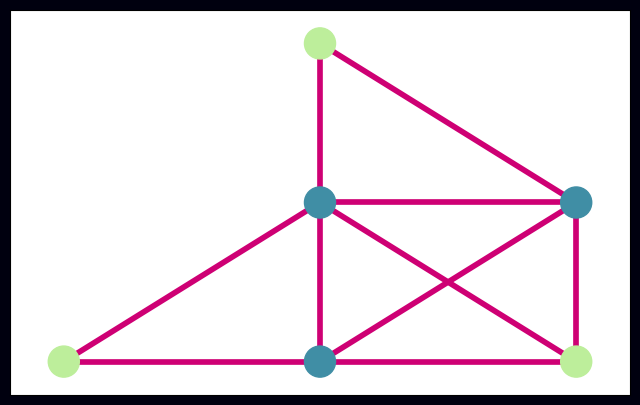

In [14]:
plot_solution(model.data, results, unit_disk_radius=unit_disk_radius)